In [ ]:
import torch
from torch import nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

AlexNet Architecture:
 ------------------------------------------------------------ 
 AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p

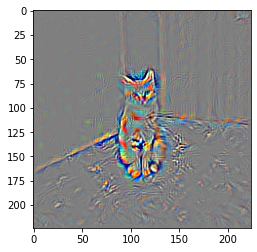

In [ ]:
class Guided_backprop():
    def __init__(self, model):
        self.model = model
        self.image_reconstruction = None # store R0
        self.activation_maps = []  # store f1, f2, ... 
        self.model.eval()
        self.register_hooks()

    def register_hooks(self):
        def first_layer_hook_fn(module, grad_in, grad_out):
            self.image_reconstruction = grad_in[0] 

        def forward_hook_fn(module, input, output):
            self.activation_maps.append(output)

        def backward_hook_fn(module, grad_in, grad_out):
            grad = self.activation_maps.pop() 
            # for the forward pass, after the ReLU operation, 
            # if the output value is positive, we set the value to 1,
            # and if the output value is negative, we set it to 0.
            grad[grad > 0] = 1 
            
            # grad_out[0] stores the gradients for each feature map,
            # and we only retain the positive gradients
            positive_grad_out = torch.clamp(grad_out[0], min=0.0)
            new_grad_in = positive_grad_out * grad

            return (new_grad_in,)


        # AlexNet model 
        modules = list(self.model.features.named_children())

        # travese the modules，register forward hook & backward hook
        # for the ReLU
        for name, module in modules:
            if isinstance(module, nn.ReLU):
                module.register_forward_hook(forward_hook_fn)
                module.register_backward_hook(backward_hook_fn)

        # register backward hook for the first conv layer
        first_layer = modules[0][1] 
        first_layer.register_backward_hook(first_layer_hook_fn)

    def visualize(self, input_image, target_class):
        model_output = self.model(input_image)
        self.model.zero_grad()
        pred_class = model_output.argmax().item()
        
        grad_target_map = torch.zeros(model_output.shape,
                                      dtype=torch.float)
        if target_class is not None:
            grad_target_map[0][target_class] = 1
        else:
            grad_target_map[0][pred_class] = 1
        
        model_output.backward(grad_target_map)
        
        result = self.image_reconstruction.data[0].permute(1,2,0)
        return result.numpy()

def normalize(image):
    norm = (image - image.mean())/image.std()
    norm = norm * 0.1
    norm = norm + 0.5
    norm = norm.clip(0, 1)
    return norm


image = Image.open('./cat.jpeg').convert('RGB') 

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


tensor = transform(image).unsqueeze(0).requires_grad_()
    
model = models.alexnet(pretrained=True)
print('AlexNet Architecture:\n', '-'*60, '\n', model, '\n', '-'*60)

guided_bp = Guided_backprop(model)
result = guided_bp.visualize(tensor, None)

result = normalize(result)
plt.imshow(result)
plt.show()